In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression
from sklearn.cross_validation import cross_val_score, cross_val_predict

C:\Users\azdoh\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\azdoh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
diabetes = datasets.load_diabetes()

(442, 10)


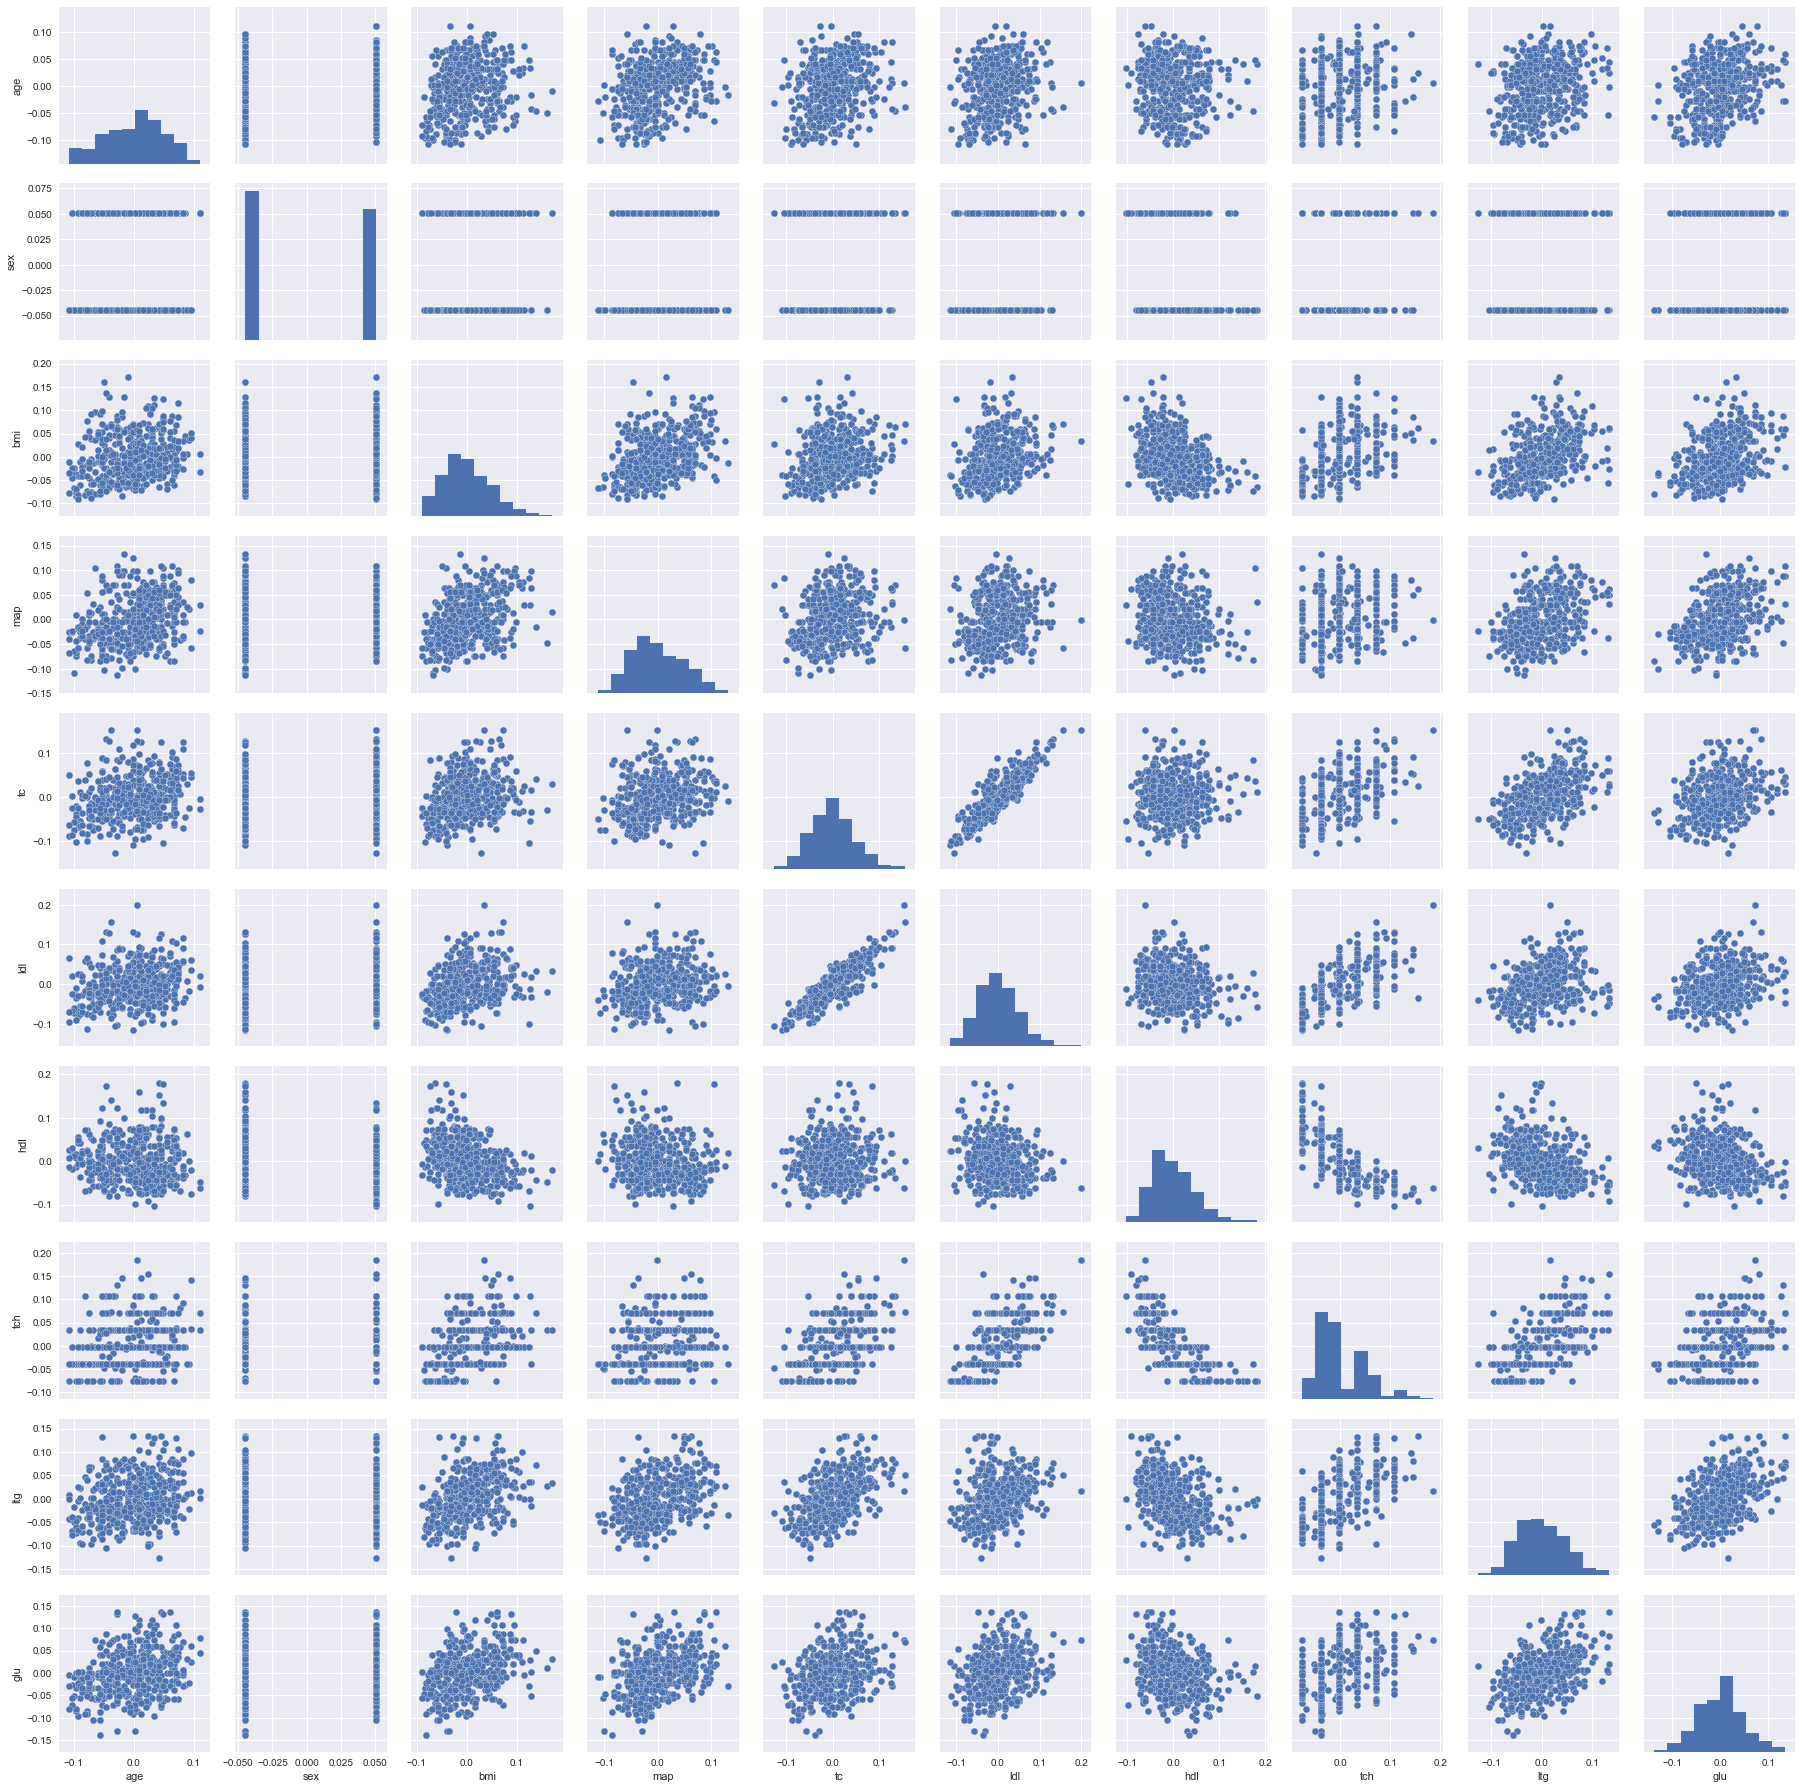

In [3]:
# View dict elements
diabetes.keys()

# View Data
print(diabetes.data.shape)
col_names = "age sex bmi map tc ldl hdl tch ltg glu".split()
data_frame = pd.DataFrame(diabetes.data, columns=col_names)
y = diabetes.target
sns.pairplot(data_frame)

In [4]:
# Check for extreme/suspicious values
for col_name in col_names:
    print(col_name,":",min(data_frame[col_name]),np.percentile(data_frame[col_name], 
        [25, 50, 75]),max(data_frame[col_name]))

age : -0.107225631607358 [-0.03729927  0.00538306  0.03807591] 0.110726675453815
sex : -0.044641636506989 [-0.04464164 -0.04464164  0.05068012] 0.0506801187398187
bmi : -0.0902752958985185 [-0.03422907 -0.00728377  0.03124802] 0.17055522598066
map : -0.112399602060758 [-0.03665645 -0.00567061  0.03564384] 0.132044217194516
tc : -0.126780669916514 [-0.03424784 -0.00432087  0.02835801] 0.153913713156516
ldl : -0.115613065979398 [-0.0303584  -0.00381907  0.02984439] 0.198787989657293
hdl : -0.10230705051742 [-0.03511716 -0.00658447  0.0293115 ] 0.181179060397284
tch : -0.076394503750001 [-0.03949338 -0.00259226  0.03430886] 0.185234443260194
ltg : -0.126097385560409 [-0.03324879 -0.00194763  0.03243323] 0.133598980013008
glu : -0.137767225690012 [-0.03317903 -0.0010777   0.02791705] 0.135611830689079


In [5]:
regr = linear_model.LinearRegression()

# LOO Cross-Validation 
scores = cross_val_score(regr, data_frame, y, cv=5)
print(scores)

[0.42955643 0.52259828 0.4826784  0.42650827 0.55024923]


First try LOO Cross-Validation using all possible models with 1, 2, 3, 4, 5, 6, 7, 8, 9, 10 variables. For each run, calculate $$RMSE = \sqrt{\frac{1}{n}\sum \limits_{i=1}^n (y_i - \widehat{y}_{(-i)})^2}$$

Then try a forward selection algorithm and see what it picks. Use the AIC criterion (or BIC).

If time try LASSO for variable selection

In [ ]:
import itertools
from sklearn.model_selection import LeaveOneOut


def looRMSE(X, y):
    loo = LeaveOneOut()
    rmse = 0
    for train, test in loo.split(X):
        regr = linear_model.LinearRegression()
        regr.fit(X[train], y[train])
        rmse += (regr.predict(X[test])[0] - y[test][0])**2
        
    rmse = np.sqrt(rmse/(X.shape[0]))
    return rmse    
        
     
tested = []
result = []
for i in range(len(col_names)):
    for j in range(1, i + 1):
        testCombos = itertools.combinations(np.arange(i), j)
        for c in testCombos:
            if set(c) in tested:
                continue
            tested.append(set(c))
            testSet = data_frame.values[:, c]
            result.append(looRMSE(testSet, y))
            print("{}, {}".format(set(c), result[-1]))
result = np.array(result)
print("{:.2f}, {}".format(result.min(), tested[result.argmin()]))
        
    
    
        

{0}, 75.95081527204351
{1}, 77.2847560422369
{0, 1}, 76.11820532265413
{2}, 62.63376523120489
{0, 2}, 62.463364783831516
{1, 2}, 62.77478371414172
{0, 1, 2}, 62.58145891624593


In [33]:
# Forward selection with AIC criterion

class ForwardSelector:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.used = np.zeros((X.shape[1])) # variables used in model, start with none

    def calculate_aic(self, y, yhat, k):
        e = np.sum((y-yhat)**2)
        aic = 2*k - 2*np.log(e)
        return aic

    def forward_select(self):
        current_best = np.iinfo(np.uint64).max
        new_best = current_best - 1
        
        while new_best < current_best:
            current_best = new_best
            candidate_scores = np.empty((self.X.shape[1]))
            print(current_best)
            for i in range(self.X.shape[1]):
                if self.used[i] == 1:
                    continue
                candidate_model = np.zeros((self.X.shape[1]))
                candidate_model[self.used==1] = 1
                candidate_model[i] = 1
                dset = self.X[:, candidate_model==1]
                regr = linear_model.LinearRegression()
                regr.fit(dset, self.y)
                yhat = regr.predict(dset)
                candidate_scores[i] = self.calculate_aic(self.y, yhat, np.sum(candidate_model))
            new_best = np.min(candidate_scores)
            print(candidate_scores)
            if new_best < current_best:
                self.used[np.argmin(candidate_scores)] = 1
                
                
fs = ForwardSelector(data_frame.values, y)
fs.forward_select()
print(fs.used)

        
        

18446744073709551614
[-27.48625919 -27.55442781 -26.71518337 -27.12454251 -27.46614936
 -27.49661389 -27.21926951 -27.14829458 -26.78615588 -27.24180401]
-27.55442781291962
[-25.48602713  27.55442781 -24.714954   -25.11393286 -25.46349287
 -25.49591368 -25.18757881 -25.12056757 -24.78089672 -25.23853077]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
# View histogram of outcome variable
plt.hist(np.sqrt(y_train))

NameError: name 'y_train' is not defined

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(diabetes_X_train, diabetes_y_train)

In [ ]:
data_frame.shape[0]

In [ ]:
y